<img src="https://s3-sa-east-1.amazonaws.com/preditiva.ai/diversos/preditiva_assinatura.jpg">

# Hands On: Fraudes no Cartão de Crédito

Referências:
- Dataset Kaggle: https://www.kaggle.com/mlg-ulb/creditcardfraud
- Lidando com dados desbalanceados: https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18
- Aula sobre Conceito Tuning Hiperparâmetros - Random Search: https://ead.preditiva.ai/74307-14-otimizacao-de-modelos/1737893-aula-2-random-search
- Aula sobre Conceito Tuning Hiperparâmetros - Otimização Bayesiana: https://ead.preditiva.ai/74307-14-otimizacao-de-modelos/1737895-aula-4-bayesian-optimization
- Aula sobre Mensuração de Valor de um Projeto: https://ead.preditiva.ai/61404-10-calculando-o-valor-de-um-projeto-de-dados-e-apresentando-os-resultados

## Importação das bibliotecas

In [ ]:
#pip install imbalanced-learn==0.7.0
#pip install hyperopt

In [1]:
# Pacotes de preparação dos dados
import numpy as np
import pandas as pd

# Pacotes gráficos
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib
matplotlib.use('module://ipykernel.pylab.backend_inline')

# Pacotes de Modelagem
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier

# Métricas de Desempenho
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from scipy.stats import ks_2samp

# Pacote para Rebalanceameto de Amostras
# Para instalar essa biblioteca utilize: pip install imbalanced-learn==0.7.0
# IMPORTANTE: Necessário scikit-learn 0.22.1 em diante
import imblearn

# Pacote para Otimização de Hiperparâmetros
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt import space_eval

In [2]:
import datetime
def log_message(message):
    print(datetime.datetime.now().strftime("%H:%M:%S - "), message)

## Definição de funções auxiliares

In [3]:
def cria_grafico_var_qualitativa(tab):

    # Aumenta o tamanho do gráfico (largura 8 e altura 4)
    fig = plt.figure(figsize=(8,4))

    # Cria um gráfico de barras usando o indice da tabela como rótulos do eixo X
    cor = np.random.rand(3)
    plt.bar(tab.index,tab['Freq_Relativa'],width = 0.7, tick_label=tab.index,color=cor,alpha=0.6)

    plt.ylim(0,tab['Freq_Relativa'].max()+0.2)
    plt.title("Frequência Relativa de {}".format(list(tab.columns)[0]))

    # cria um conjunto de pares de rótulos e frequencias relativas
    for x,y in zip(tab.index,tab['Freq_Relativa']):

        # formata o rotulo do percentual
        rotulo = "{:.4f}".format(y)

        # coloca o rotulo na posição (x,y), alinhado ao centro e com distância 0,5 do ponto (x,y)
        plt.annotate(rotulo,(x,y),ha='center',textcoords="offset points",xytext=(0,5))
                
def tabela_bivariada(data, var):
    
    df = pd.DataFrame(data[var].value_counts().sort_values(ascending=False).rename(var))
    total = df[var].sum()
    df['Freq_Relativa'] = (df[var]/total).round(decimals=4)
    df['Freq_Acumulada'] = df['Freq_Relativa'].cumsum().round(decimals=4)
    return df

# Função para cálculo do KS
def ks_stat(y, y_pred):
    return ks_2samp(y_pred[y==1], y_pred[y!=1]).statistic

# Função para cálculo do desempenho de modelos
def calcula_desempenho(modelo, x_train, y_train, x_test, y_test):

    # Cálculo dos valores preditos
    ypred_train = modelo.predict(x_train)
    ypred_proba_train = modelo.predict_proba(x_train)[:,1]

    ypred_test = modelo.predict(x_test)
    ypred_proba_test = modelo.predict_proba(x_test)[:,1]

    # Métricas de Desempenho
    acc_train = accuracy_score(y_train, ypred_train)
    acc_test = accuracy_score(y_test, ypred_test)
    
    roc_train = roc_auc_score(y_train, ypred_proba_train)
    roc_test = roc_auc_score(y_test, ypred_proba_test)
    
    ks_train = ks_stat(y_train, ypred_proba_train)
    ks_test = ks_stat(y_test, ypred_proba_test)
    
    prec_train = precision_score(y_train, ypred_train, zero_division=0)
    prec_test = precision_score(y_test, ypred_test, zero_division=0)
    
    recl_train = recall_score(y_train, ypred_train)
    recl_test = recall_score(y_test, ypred_test)
    
    f1_train = f1_score(y_train, ypred_train)
    f1_test = f1_score(y_test, ypred_test)

    df_desemp = pd.DataFrame({'Treino':[acc_train, roc_train, ks_train, 
                                        prec_train, recl_train, f1_train],
                              'Teste':[acc_test, roc_test, ks_test,
                                       prec_test, recl_test, f1_test]},
                            index=['Acurácia','AUROC','KS',
                                   'Precision','Recall','F1'])
    
    df_desemp['Variação'] = round(df_desemp['Teste'] / df_desemp['Treino'] - 1, 2)
    
    return df_desemp

def plot_confusion_matrix(modelo,X,y):
    y_pred = modelo.predict(X)
    cm = confusion_matrix(y, y_pred, normalize='all')
    return ConfusionMatrixDisplay(cm).plot()
    
def matriz_confusao(modelo, X_train, y_train, X_test, y_test):
    plot_confusion_matrix(modelo, X_train, y_train)
    plt.title('Treino')    
    plot_confusion_matrix(modelo, X_test, y_test)
    plt.title('Teste')

## Importação da base de dados

In [4]:
df = pd.read_csv('creditcard.zip')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Preparação dos Dados

### Missing Values

In [5]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

### Duplicações

In [6]:
df.duplicated().sum()

1081

In [7]:
df.drop_duplicates(inplace=True)

### Tipos de Variáveis

In [8]:
df.head(2)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 283726 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    283726 non-null  float64
 1   V1      283726 non-null  float64
 2   V2      283726 non-null  float64
 3   V3      283726 non-null  float64
 4   V4      283726 non-null  float64
 5   V5      283726 non-null  float64
 6   V6      283726 non-null  float64
 7   V7      283726 non-null  float64
 8   V8      283726 non-null  float64
 9   V9      283726 non-null  float64
 10  V10     283726 non-null  float64
 11  V11     283726 non-null  float64
 12  V12     283726 non-null  float64
 13  V13     283726 non-null  float64
 14  V14     283726 non-null  float64
 15  V15     283726 non-null  float64
 16  V16     283726 non-null  float64
 17  V17     283726 non-null  float64
 18  V18     283726 non-null  float64
 19  V19     283726 non-null  float64
 20  V20     283726 non-null  float64
 21  V21     283726 

## Análise Exploratória dos Dados

### Distribuição das classes: Fraude / Não Fraude

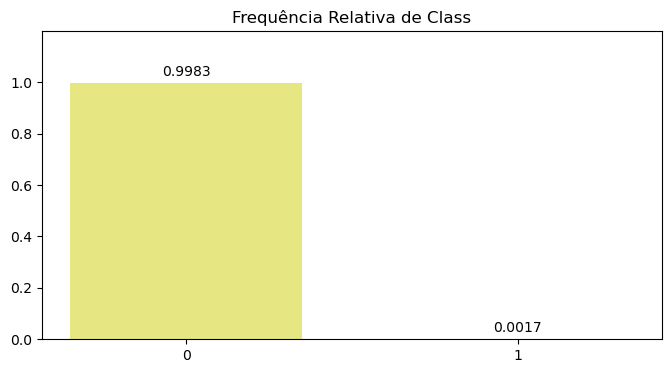

In [10]:
cria_grafico_var_qualitativa(tabela_bivariada(df,'Class'))

In [11]:
tabela_bivariada(df, 'Class')

,Class,Freq_Relativa,Freq_Acumulada
Class,,,
0,283253,0.9983,0.9983
1,473,0.0017,1.0000


## Desenvolvimento dos Modelos

### Definição do *Target* e das *Features*

In [12]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [13]:
# Target (variável resposta)
y_var = 'Class'
y = df[y_var]

# Features (variáveis explicativas)
# Variáveis Numéricas
x_var_num = [
    'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
    'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',
    'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',
    'Amount'
    ]
x_num = df[x_var_num].to_numpy()

### Divisão das bases em Treino e Teste

In [14]:
# Divisão em treino e teste
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_num, y, 
                                                    test_size=0.30,
                                                    random_state=42)

### Criação de modelo baseline

In [15]:
# função para modelo Gradient Boosting
def modelo_GB(min_samples_leaf=10, max_depth=3,n_estimators=50, random_state=42, subsample=0.5):
    
    # Definição da estrutura do modelo
    model = GradientBoostingClassifier(
        n_estimators=n_estimators, 
        subsample=subsample,
        min_samples_leaf=min_samples_leaf,
        max_depth=max_depth, 
        random_state=42
    )
    return model

In [16]:
# Treinamento de um modelo Gradient Boosting
modelo_base = modelo_GB()
modelo_base.fit(x_train, y_train)

GradientBoostingClassifier(min_samples_leaf=10, n_estimators=50,
                           random_state=42, subsample=0.5)

In [17]:
modelo_base_desemp = calcula_desempenho(modelo_base,
                                        x_train, y_train,
                                        x_test, y_test)
modelo_base_desemp

,Treino,Teste,Variação
Acurácia,0.998993,0.998896,-0.00
AUROC,0.805145,0.779668,-0.03
KS,0.730575,0.685002,-0.06
Precision,0.702624,0.647059,-0.08
Recall,0.710914,0.656716,-0.08
F1,0.706745,0.651852,-0.08


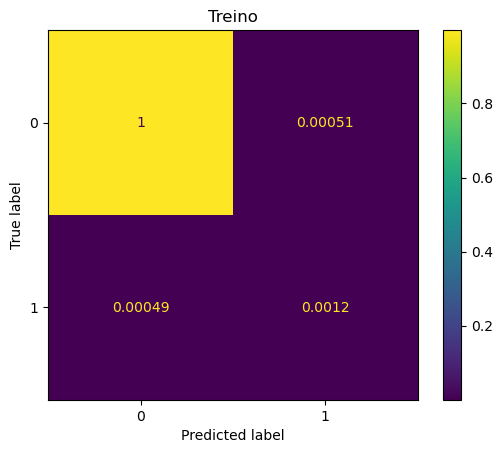

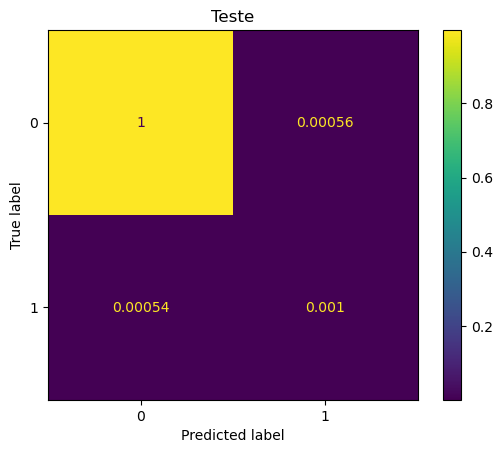

In [18]:
modelo_base_matriz_confusao = matriz_confusao(modelo_base,
                                              x_train, y_train,
                                              x_test, y_test)

modelo_base_matriz_confusao

## Reamostragem dos Dados de Treino

### Random Oversampling

In [19]:
# IMPORTANTE: a reamostragem deve ser feita APENAS na base de Treino
rnd_over = imblearn.over_sampling.RandomOverSampler(sampling_strategy=0.2,
                                                    random_state=42)
x_train_over, y_train_over = rnd_over.fit_resample(x_train, y_train)

print('Shape do y_train: ', y_train.shape)
print('Shape do y_train_over: ', y_train_over.shape)

Shape do y_train:  (198608,)
Shape do y_train_over:  (237922,)


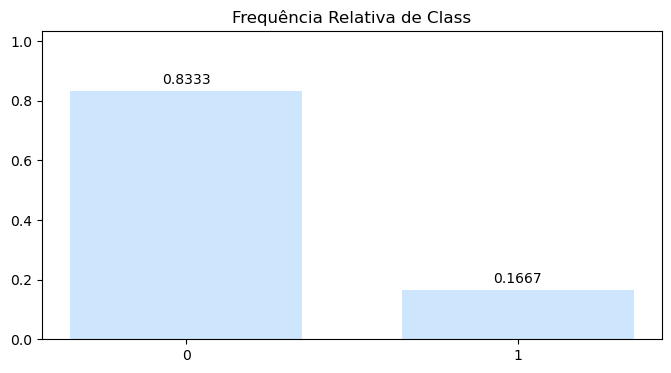

In [20]:
cria_grafico_var_qualitativa(tabela_bivariada(pd.DataFrame(y_train_over),'Class'))

In [21]:
# Treinamento de um modelo Gradient Boosting com Random Oversampling
modelo_ro = modelo_GB()
modelo_ro.fit(x_train_over, y_train_over)

GradientBoostingClassifier(min_samples_leaf=10, n_estimators=50,
                           random_state=42, subsample=0.5)

In [22]:
modelo_ro_desemp = calcula_desempenho(modelo_ro,
                                      x_train_over, y_train_over,
                                      x_test, y_test)
modelo_ro_desemp

,Treino,Teste,Variação
Acurácia,0.986353,0.997486,0.01
AUROC,0.998174,0.977470,-0.02
KS,0.977066,0.883817,-0.10
Precision,0.989881,0.369281,-0.63
Recall,0.927597,0.843284,-0.09
F1,0.957727,0.513636,-0.46


In [23]:
modelo_base_desemp

,Treino,Teste,Variação
Acurácia,0.998993,0.998896,-0.00
AUROC,0.805145,0.779668,-0.03
KS,0.730575,0.685002,-0.06
Precision,0.702624,0.647059,-0.08
Recall,0.710914,0.656716,-0.08
F1,0.706745,0.651852,-0.08


### SMOTE Oversampling

In [24]:
over_smote = imblearn.over_sampling.SMOTE(sampling_strategy=0.2,
                                          random_state=42, 
                                          n_jobs=4)
x_train_over_smote, y_train_over_smote = over_smote.fit_resample(x_train, y_train)

print('Shape do y_train: ', y_train.shape)
print('Shape do y_train_over: ', y_train_over_smote.shape)

Shape do y_train:  (198608,)
Shape do y_train_over:  (237922,)


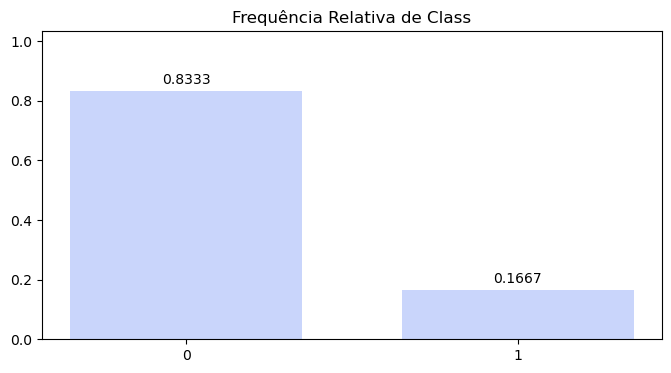

In [25]:
cria_grafico_var_qualitativa(tabela_bivariada(pd.DataFrame(y_train_over_smote),'Class'))

In [26]:
# Treinamento de um modelo Gradient Boosting com SMOTE Oversampling
modelo_smote = modelo_GB()
modelo_smote.fit(x_train_over_smote, y_train_over_smote)

GradientBoostingClassifier(min_samples_leaf=10, n_estimators=50,
                           random_state=42, subsample=0.5)

In [27]:
modelo_smote_desemp = calcula_desempenho(modelo_smote, 
                                         x_train_over_smote, y_train_over_smote,
                                         x_test, y_test)
modelo_smote_desemp

,Treino,Teste,Variação
Acurácia,0.983709,0.997110,0.01
AUROC,0.995106,0.976996,-0.02
KS,0.938164,0.894344,-0.05
Precision,0.988610,0.335294,-0.66
Recall,0.912768,0.850746,-0.07
F1,0.949177,0.481013,-0.49


In [28]:
modelo_base_desemp

,Treino,Teste,Variação
Acurácia,0.998993,0.998896,-0.00
AUROC,0.805145,0.779668,-0.03
KS,0.730575,0.685002,-0.06
Precision,0.702624,0.647059,-0.08
Recall,0.710914,0.656716,-0.08
F1,0.706745,0.651852,-0.08


### Random Undersampling

In [29]:
# IMPORTANTE: a reamostragem deve ser feita APENAS na base de Treino
rnd_under = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=0.2,
                                                       random_state=42)
x_train_under, y_train_under = rnd_under.fit_resample(x_train, y_train)

print('Shape do y_train: ', y_train.shape)
print('Shape do y_train_under: ', y_train_under.shape)

Shape do y_train:  (198608,)
Shape do y_train_under:  (2034,)


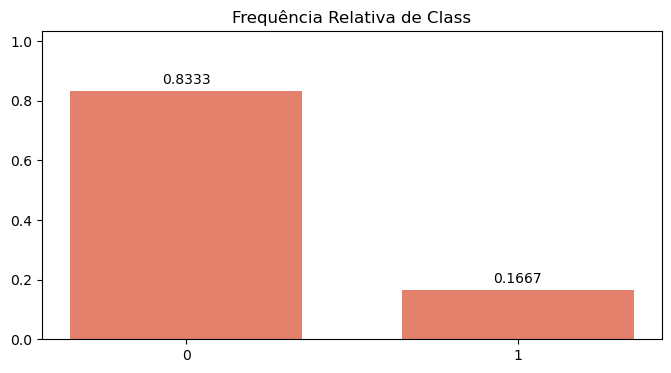

In [30]:
cria_grafico_var_qualitativa(tabela_bivariada(pd.DataFrame(y_train_under),'Class'))

In [31]:
tabela_bivariada(pd.DataFrame(y_train), 'Class')

,Class,Freq_Relativa,Freq_Acumulada
Class,,,
0,198269,0.9983,0.9983
1,339,0.0017,1.0000


In [32]:
tabela_bivariada(pd.DataFrame(y_train_under), 'Class')

,Class,Freq_Relativa,Freq_Acumulada
Class,,,
0,1695,0.8333,0.8333
1,339,0.1667,1.0000


In [33]:
# Treinamento de um modelo Gradient Boosting com Random Undersampling
modelo_ru = modelo_GB()
modelo_ru.fit(x_train_under, y_train_under)

GradientBoostingClassifier(min_samples_leaf=10, n_estimators=50,
                           random_state=42, subsample=0.5)

In [34]:
modelo_ru_desemp = calcula_desempenho(modelo_ru,
                                      x_train_under, y_train_under,
                                      x_test, y_test)
modelo_ru_desemp

,Treino,Teste,Variação
Acurácia,0.984759,0.993151,0.01
AUROC,0.997061,0.977337,-0.02
KS,0.959882,0.868703,-0.09
Precision,0.996774,0.169367,-0.83
Recall,0.911504,0.858209,-0.06
F1,0.952234,0.282903,-0.70


In [35]:
modelo_base_desemp

,Treino,Teste,Variação
Acurácia,0.998993,0.998896,-0.00
AUROC,0.805145,0.779668,-0.03
KS,0.730575,0.685002,-0.06
Precision,0.702624,0.647059,-0.08
Recall,0.710914,0.656716,-0.08
F1,0.706745,0.651852,-0.08


### Tomek Link Undersampling

In [36]:
# IMPORTANTE: a reamostragem deve ser feita APENAS na base de Treino
log_message('Iniciando Tomek Link Undersampling...')
under_tomek = imblearn.under_sampling.TomekLinks(sampling_strategy='auto',
                                                 n_jobs=4)
x_train_under_tomek, y_train_under_tomek = under_tomek.fit_resample(x_train, y_train)

log_message('Concluída preparação Tomek Link Undersampling!')
print('Shape do y_train: ', y_train.shape)
print('Shape do y_train_tomek: ', y_train_under_tomek.shape)

15:47:06 -  Iniciando Tomek Link Undersampling...
15:49:37 -  Concluída preparação Tomek Link Undersampling!
Shape do y_train:  (198608,)
Shape do y_train_tomek:  (198586,)


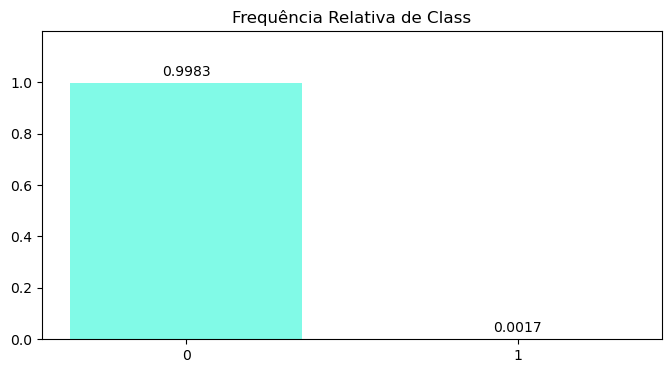

In [37]:
cria_grafico_var_qualitativa(tabela_bivariada(pd.DataFrame(y_train_under_tomek),'Class'))

In [38]:
# Treinamento de um modelo Gradient Boosting com Tomek Link Undersampling
modelo_tomek = modelo_GB()
modelo_tomek.fit(x_train_under_tomek, y_train_under_tomek)

GradientBoostingClassifier(min_samples_leaf=10, n_estimators=50,
                           random_state=42, subsample=0.5)

In [39]:
modelo_tomek_desemp = calcula_desempenho(modelo_tomek,
                                         x_train_under_tomek, y_train_under_tomek,
                                         x_test, y_test)
modelo_tomek_desemp

,Treino,Teste,Variação
Acurácia,0.998781,0.998520,-0.00
AUROC,0.906514,0.876194,-0.03
KS,0.829639,0.781005,-0.06
Precision,0.604301,0.520000,-0.14
Recall,0.828909,0.776119,-0.06
F1,0.699005,0.622754,-0.11


In [40]:
modelo_base_desemp

,Treino,Teste,Variação
Acurácia,0.998993,0.998896,-0.00
AUROC,0.805145,0.779668,-0.03
KS,0.730575,0.685002,-0.06
Precision,0.702624,0.647059,-0.08
Recall,0.710914,0.656716,-0.08
F1,0.706745,0.651852,-0.08


### Combinação SMOTE + Tomek

In [41]:
# IMPORTANTE: a reamostragem deve ser feita APENAS na base de Treino
log_message('Iniciando SMOTE + Tomek Link Undersampling...')
smote_tomek = imblearn.combine.SMOTETomek(sampling_strategy='auto', 
                                          random_state=42,
                                          smote=over_smote,
                                          tomek=under_tomek,
                                          n_jobs=-1)
x_train_smote_tomek, y_train_smote_tomek = smote_tomek.fit_resample(x_train, y_train)
log_message('Concluída preparação SMOTE + Tomek Link Undersampling!')

print('Shape do y_train: ', y_train.shape)
print('Shape do y_train_smote_tomek: ', y_train_smote_tomek.shape)

15:54:51 -  Iniciando SMOTE + Tomek Link Undersampling...
15:58:30 -  Concluída preparação SMOTE + Tomek Link Undersampling!
Shape do y_train:  (198608,)
Shape do y_train_smote_tomek:  (237905,)


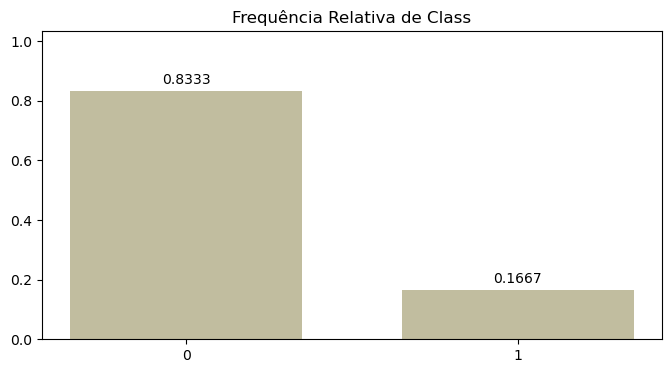

In [42]:
cria_grafico_var_qualitativa(tabela_bivariada(pd.DataFrame(y_train_smote_tomek),'Class'))

In [43]:
# Treinamento de um modelo Gradient Boosting com SMOTE + Tomek Link Resampling
modelo_smote_tomek = modelo_GB()
modelo_smote_tomek.fit(x_train_smote_tomek, y_train_smote_tomek)

GradientBoostingClassifier(min_samples_leaf=10, n_estimators=50,
                           random_state=42, subsample=0.5)

In [44]:
modelo_smote_tomek_desemp = calcula_desempenho(modelo_smote_tomek, 
                   x_train_smote_tomek, y_train_smote_tomek,
                   x_test, y_test)
modelo_smote_tomek_desemp

,Treino,Teste,Variação
Acurácia,0.983384,0.997004,0.01
AUROC,0.995102,0.979443,-0.02
KS,0.938536,0.902969,-0.04
Precision,0.988426,0.325648,-0.67
Recall,0.910978,0.843284,-0.07
F1,0.948123,0.469854,-0.50


In [45]:
modelo_base_desemp

,Treino,Teste,Variação
Acurácia,0.998993,0.998896,-0.00
AUROC,0.805145,0.779668,-0.03
KS,0.730575,0.685002,-0.06
Precision,0.702624,0.647059,-0.08
Recall,0.710914,0.656716,-0.08
F1,0.706745,0.651852,-0.08


### Melhor técnica (referência: maior Recall)

In [46]:
pd.Series(data = {'Modelo Base': modelo_base_desemp.loc['Recall','Teste'],
                  'Modelo Random Oversampling': modelo_ro_desemp.loc['Recall','Teste'],
                  'Modelo SMOTE Oversampling': modelo_smote_desemp.loc['Recall','Teste'],
                  'Modelo Random Undersampling': modelo_ru_desemp.loc['Recall','Teste'],
                  'Modelo Tomek Link Undersampling': modelo_tomek_desemp.loc['Recall','Teste'],
                  'Modelo SMOTE + Tomek': modelo_smote_tomek_desemp.loc['Recall','Teste'],
                    }).sort_values(ascending=False)

Modelo Random Undersampling        0.858209
Modelo SMOTE Oversampling          0.850746
Modelo Random Oversampling         0.843284
Modelo SMOTE + Tomek               0.843284
Modelo Tomek Link Undersampling    0.776119
Modelo Base                        0.656716
dtype: float64

**Conclusão**:  
Entre as técnicas para tratamento de amostras desbalanceadas, a que resultou em maior Recall foi a de _Random Undersampling_.  
Deve-se considerar no entanto, que as técnicas SMOTE, Random Oversampling e SMOTE Tomek apresentaram resultados de Recall bastante próximos ao primeiro colocado.  
Entre todas, destaca-se a técnica de Random Undersampling, com resultado de Recall bastante similar e tempo de treinamento do modelo muito mais rápido em função do menor tamanho do dataset de treino.

In [47]:
# Avaliação da generalização do modelo
pd.Series(data = {'Modelo Base': modelo_base_desemp.loc['Recall','Variação'],
                  'Modelo Random Oversampling': modelo_ro_desemp.loc['Recall','Variação'],
                  'Modelo SMOTE Oversampling': modelo_smote_desemp.loc['Recall','Variação'],
                  'Modelo Random Undersampling': modelo_ru_desemp.loc['Recall','Variação'],
                  'Modelo Tomek Link Undersampling': modelo_tomek_desemp.loc['Recall','Variação'],
                  'Modelo SMOTE + Tomek': modelo_smote_tomek_desemp.loc['Recall','Variação'],
                    }).sort_values(ascending=False)

Modelo Random Undersampling       -0.06
Modelo Tomek Link Undersampling   -0.06
Modelo SMOTE Oversampling         -0.07
Modelo SMOTE + Tomek              -0.07
Modelo Base                       -0.08
Modelo Random Oversampling        -0.09
dtype: float64

## Otimização dos Modelos

In [48]:
# Número mínimo de amostras por folha
ehp_min_samples_leaf = np.arange(5, 26, 5)

# Máxima profundidade
ehp_max_depth = [2, 3, 4, 5]

# Número de estimadores
ehp_n_estimators = [10, 20, 50, 100, 150, 200]

# Amostragem de observações usadas para cada árvore
ehp_subsample = [0.1, 0.2, 0.3, 0.4, 0.5]

# Definição do dicionário de parâmetros
param_grid = dict(min_samples_leaf=ehp_min_samples_leaf,
                  max_depth=ehp_max_depth,
                  n_estimators=ehp_n_estimators,
                  subsample=ehp_subsample
                 )

In [49]:
param_grid

{'min_samples_leaf': array([ 5, 10, 15, 20, 25]),
 'max_depth': [2, 3, 4, 5],
 'n_estimators': [10, 20, 50, 100, 150, 200],
 'subsample': [0.1, 0.2, 0.3, 0.4, 0.5]}

### Random Search

In [50]:
log_message('Iniciando Random Search...')
modelo_random = RandomizedSearchCV(estimator=modelo_base, 
                                   param_distributions=param_grid,
                                   n_iter=100, #n_iter=10,
                                   n_jobs=5,
                                   cv=2,
                                   verbose=4,
                                   random_state=42)

modelo_random.fit(x_train_under, y_train_under)
log_message('Random Search finalizado!')

16:11:08 -  Iniciando Random Search...
Fitting 2 folds for each of 100 candidates, totalling 200 fits
16:12:26 -  Random Search finalizado!


In [51]:
modelo_random.best_estimator_

GradientBoostingClassifier(max_depth=2, min_samples_leaf=15, n_estimators=50,
                           random_state=42, subsample=0.3)

In [52]:
modelo_random_desemp = calcula_desempenho(modelo_random.best_estimator_,
                                          x_train_under, y_train_under,
                                          x_test,  y_test)
modelo_random_desemp

,Treino,Teste,Variação
Acurácia,0.977876,0.993820,0.02
AUROC,0.989403,0.975889,-0.01
KS,0.912684,0.866068,-0.05
Precision,0.983553,0.181818,-0.82
Recall,0.882006,0.835821,-0.05
F1,0.930016,0.298667,-0.68


### Bayesian Optimization

Referência - Distância Euclidiana: https://pt.wikipedia.org/wiki/Dist%C3%A2ncia_euclidiana

In [53]:
param_grid

{'min_samples_leaf': array([ 5, 10, 15, 20, 25]),
 'max_depth': [2, 3, 4, 5],
 'n_estimators': [10, 20, 50, 100, 150, 200],
 'subsample': [0.1, 0.2, 0.3, 0.4, 0.5]}

In [54]:
bo_space = {'min_samples_leaf': hp.choice('min_samples_leaf', param_grid['min_samples_leaf']),
            'max_depth': hp.choice('max_depth', param_grid['max_depth']),
            'n_estimators': hp.choice('n_estimators', param_grid['n_estimators']),
            'subsample': hp.choice('subsample', param_grid['subsample'])
           }

In [55]:
def bo_gb(param):   

    print ('Hiperparametros testados: ', param)
    modelo_bo = modelo_GB(min_samples_leaf=param['min_samples_leaf'],
                          max_depth=param['max_depth'],
                          n_estimators=param['n_estimators'],
                          subsample=param['subsample']
                         )
    
    #modelo_bo.fit(x_train, y_train)
    modelo_bo.fit(x_train_under, y_train_under)

    # Previsões para treino e teste
    #y_train_pred = modelo_bo.predict(x_train)
    y_train_pred = modelo_bo.predict(x_train_under)
    y_test_pred = modelo_bo.predict(x_test)

    
    # Cálculo do recall de treino e teste
    #recall_train = recall_score(y_train, y_train_pred)
    recall_train = recall_score(y_train_under, y_train_pred)
    recall_test = recall_score(y_test, y_test_pred)
    recall_diff = np.abs(recall_train - recall_test)
    
    # Exemplo de função : maximizar o recall e minimizar a diferença entre recall de treino e teste
    #score = -recall_test

    # Função para cálculo da distância euclidiana entre o resultado obtido e o ideal, 
    # para maximizar o recall (ideal = 1) e minimizar a diferença entre recall de treino e teste (ideal = 0)
    score = np.sqrt((recall_test - 1) ** 2 + (recall_diff - 0) ** 2)
    
    # Calcula AuROC no conjunto de Teste
    y_test_pred_proba = modelo_bo.predict_proba(x_test)[:,1]
    auroc_test = roc_auc_score(y_test, y_test_pred_proba)
    
    print(f'AuROC Teste: {auroc_test} | Recall Teste: {recall_test} | Variação: {recall_diff}')
    
    return {'loss': score, 'status': STATUS_OK}

In [56]:
trials = Trials()
bo_search = fmin(fn=bo_gb,
                 space=bo_space,
                 algo=tpe.suggest,
                 max_evals=100, #max_evals=10,
                 trials=trials)

Hiperparametros testados:                                                                                              
{'max_depth': 4, 'min_samples_leaf': 25, 'n_estimators': 150, 'subsample': 0.1}                                        
AuROC Teste: 0.9561124587455269 | Recall Teste: 0.835820895522388 | Variação: 0.075683529256373                        
Hiperparametros testados:                                                                                              
{'max_depth': 3, 'min_samples_leaf': 15, 'n_estimators': 200, 'subsample': 0.2}                                        
AuROC Teste: 0.9631392423648489 | Recall Teste: 0.8731343283582089 | Variação: 0.08261788403117165                     
Hiperparametros testados:                                                                                              
{'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 10, 'subsample': 0.2}                                          
AuROC Teste: 0.969016160724196 | Recall 

In [57]:
bo_melhor_hp = space_eval(bo_space, bo_search)
print('Melhor conjunto de hiperparâmetros: ', bo_melhor_hp)

Melhor conjunto de hiperparâmetros:  {'max_depth': 2, 'min_samples_leaf': 5, 'n_estimators': 150, 'subsample': 0.2}


### Melhor Modelo (referência: maior Recall e menor variação entre treino e teste)

In [58]:
# Utilizando o melhor conjunto de hiperparâmetros para treino com a melhor técnica para amostras desbalanceadas
modelo_bo = modelo_GB(min_samples_leaf=bo_melhor_hp['min_samples_leaf'],
                          max_depth=bo_melhor_hp['max_depth'],
                          n_estimators=bo_melhor_hp['n_estimators'],
                          subsample=bo_melhor_hp['subsample']
                     )

historico = modelo_bo.fit(x_train_under, y_train_under)

In [59]:
modelo_bo_desemp = calcula_desempenho(modelo_bo,
                                      x_train_under, y_train_under,
                                      x_test,  y_test)
modelo_bo_desemp

,Treino,Teste,Variação
Acurácia,0.983776,0.990014,0.01
AUROC,0.996394,0.975276,-0.02
KS,0.948673,0.869412,-0.08
Precision,0.993548,0.123158,-0.88
Recall,0.908555,0.873134,-0.04
F1,0.949153,0.215867,-0.77


In [60]:
pd.Series(data = {'Modelo Base': modelo_base_desemp.loc['Recall','Teste'],
                  'Modelo Random Undersampling': modelo_ru_desemp.loc['Recall','Teste'],
                  'Modelo Random Search Random Undersampling': modelo_random_desemp.loc['Recall','Teste'],
                  'Modelo Bayesian Optimized': modelo_bo_desemp.loc['Recall','Teste'],
                    }).sort_values(ascending=False)

Modelo Bayesian Optimized                    0.873134
Modelo Random Undersampling                  0.858209
Modelo Random Search Random Undersampling    0.835821
Modelo Base                                  0.656716
dtype: float64

In [61]:
pd.Series(data = {'Modelo Base': modelo_base_desemp.loc['Recall','Variação'],
                  'Modelo Random Undersampling': modelo_ru_desemp.loc['Recall','Variação'],
                  'Modelo Random Search Random Undersampling': modelo_random_desemp.loc['Recall','Variação'],
                  'Modelo Bayesian Optimized': modelo_bo_desemp.loc['Recall','Variação'],
                    }).sort_values(ascending=False)

Modelo Bayesian Optimized                   -0.04
Modelo Random Search Random Undersampling   -0.05
Modelo Random Undersampling                 -0.06
Modelo Base                                 -0.08
dtype: float64

O Modelo desenvolvido com a técnica de Random UnderSampling para tratamento do dataset desbalanceado, aliado à técnica de Otimização Bayesiana para finetuning de hiperparâmetros, apresentou os melhores resultados do ponto de vista de melhor recall e melhor generalização (menor variação entre treino e teste).

## Mensuração do Valor

Do ponto de vista do negócio, considerando que o custo do Falso Negativo é 1000 reais e o custo do Falso Positivo é 500 reais, qual é valor de se aplicar as técnicas de oversampling/ undersampling e finetuning dos modelos?

In [62]:
#Custo Falso Negativo
custo_fn = 1000
#Custo Falso Positivo
custo_fp = 500

In [63]:
# Modelo Base
y_pred_base = modelo_base.predict(x_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_base, normalize='all').ravel()
print(tn, fp, fn, tp)

0.9978617918654104 0.0005639230245071548 0.0005404262318193567 0.001033858878263117


In [64]:
# Valor do Modelo Base
valor_base = fp*custo_fp + fn*custo_fn
valor_base

0.8223877440729341

In [65]:
# Modelo UnderSampling
y_pred_ru = modelo_ru.predict(x_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_ru, normalize='all').ravel()
print(tn, fp, fn, tp)

0.9917996193519585 0.006626095537959068 0.00022321953053408208 0.0013510655795483917


In [66]:
# Valor do Modelo Undersampling
valor_ru = fp*custo_fp + fn*custo_fn
valor_ru

3.536267299513616

In [67]:
# Modelo com Finetuning
y_pred_optimized = modelo_bo.predict(x_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_optimized, normalize='all').ravel()
print(tn, fp, fn, tp)

0.9886393007354496 0.009786414154467914 0.00019972273784628399 0.0013745623722361898


In [68]:
# Valor do Modelo com Finetuning
valor_bo = fp*custo_fp + fn*custo_fn
valor_bo

5.092929815080241

# Para ir além...

Para explorar outras possibilidades de resolução do desafio proposto, considere também:  

1) Para otimizar conjuntamente a escolha da técnica oversampling/undersampling com o finetuning dos hiperparâmetros, explore os recursos de pipeline do sklearn e impalanced-learn:  
- https://imbalanced-learn.org/stable/auto_examples/pipeline/plot_pipeline_classification.html
- https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline

2) Adaptar a função customizada do score para considerar os custos de falsos negativos e falsos positivos
